In [1]:
import pandas as pd
import numpy as np
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import ensemble
from matplotlib import style
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
%matplotlib inline        

Перед началом, добавим некоторые функции

In [2]:
def missing_value_of_data(data):
    ''' Выявляет пропуски'''
    total=data.isnull().sum().sort_values(ascending=False)
    percentage=round(total/data.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

def unique_values_in_column(data,feature):
    ''' Выводит уникальные значения'''
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

def my_hist(x, figsize=(14, 3)):
    ''' Гисторграмма + медиана/мода/средн.арихфм. '''
    target_mean = round(x.mean(), 2)
    target_median = x.median()
    target_mode = x.mode()[0]

    plt.figure(figsize=figsize)

    sns.distplot(x, bins=min(50,len(set(x.unique()))))

    plt.axvline(x=[target_mean], label='mean',
                linestyle=':', color="red", linewidth=4)
    plt.axvline(x=[target_median], label='median',
                linestyle='--', color="green", linewidth=4)
    plt.axvline(x=[target_mode], label='mode',
                linestyle='-.', color="brown", linewidth=4)

    plt.title(f'Distribution of {x.name}')
    plt.xlabel(x.name)
    plt.ylabel('Frequency')
    plt.show()

def my_boxplot(x,y,ampX=1,ampY=1, f_e=(14, 3)):
    """ Боксплот для оценки связи параметров """
    plt.figure(figsize = f_e)
    x_s = (round(x/ampX,0)*ampX).astype(np.int32)
    y_s = (round(y/ampY,0)*ampY).astype(np.int32)    
    
    sns.boxplot(x_s, y_s)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.title(f'Distribution of {x.name} by {y.name}')
    plt.show()
    
def plot_feature_importances(importances, X):

    indices = np.argsort(importances)[::-1]
    """ для оценки влияния параметров на модель """
    plt.figure(figsize=(20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
            color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.show()

1. Чтение данных

In [3]:
df = pd.read_csv('train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('test.csv')

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

2. Исследование данных

Исследуем данные для вычесление выбросов.

In [6]:
X['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

На данном этапе выбросами являются 0 комнат, 10, 19, 6. Так как физически не влезут в одну квартиру.

In [7]:
X['KitchenSquare'].value_counts().sort_values()

54.0         1
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
42.0         1
62.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
63.0         1
53.0         1
30.0         2
58.0         2
32.0         2
51.0         2
43.0         2
25.0         2
112.0        2
41.0         2
37.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

2014, 1970, and <3 = являются выбросами

Floor, HouseFloor

In [8]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

0, 99, 117 =являются выбросами

In [9]:
X['Floor'].sort_values()

Id
8231      1
11272     1
7713      1
8187      1
8474      1
         ..
3298     32
11563    32
8016     33
8296     37
1674     42
Name: Floor, Length: 10000, dtype: int64

In [10]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

Год постройки домов

In [11]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

 4968,20052011=являются выбросами

Заполняем Nan

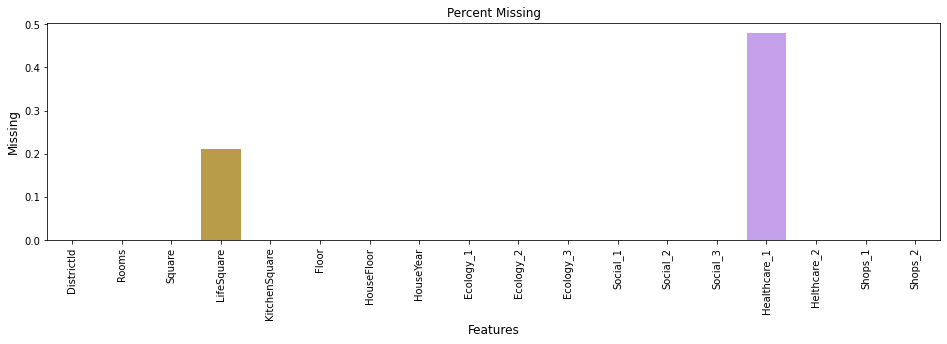

In [12]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Необходимо удалить HealthyCare_1

Сравниваем:
    DistrictId, Rooms,Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear. 

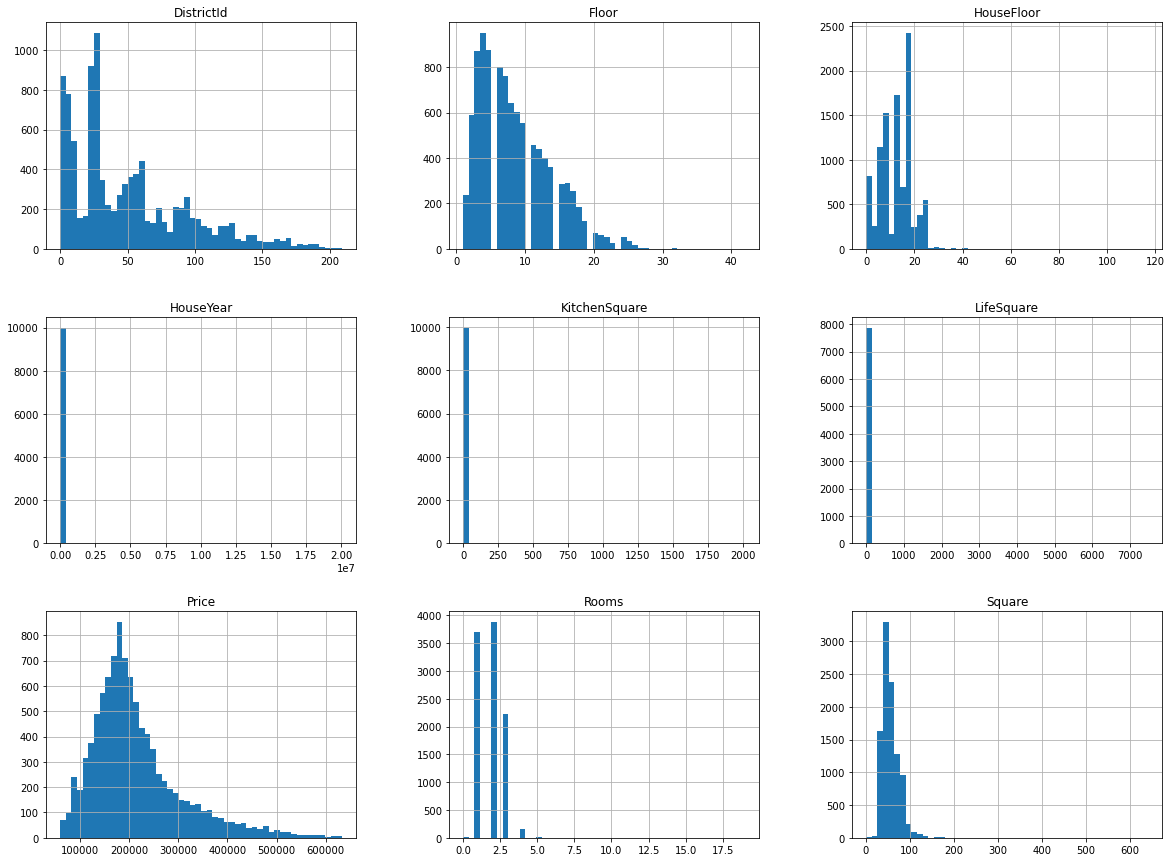

In [13]:
df[['DistrictId','Floor','HouseFloor','HouseYear','KitchenSquare','Rooms','Square','LifeSquare','Price']].hist(bins=50, figsize=(20,15))
plt.show()

Healthcare_1

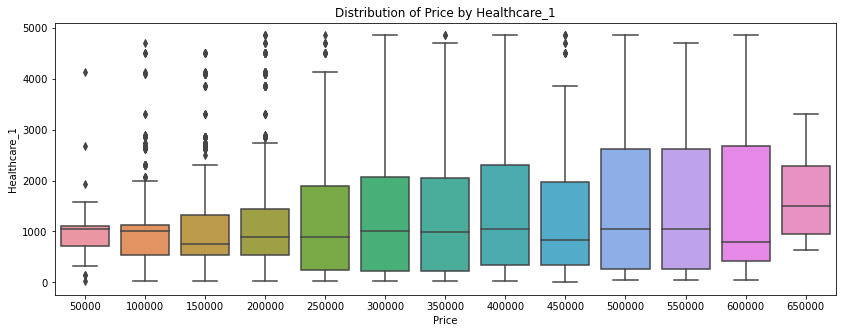

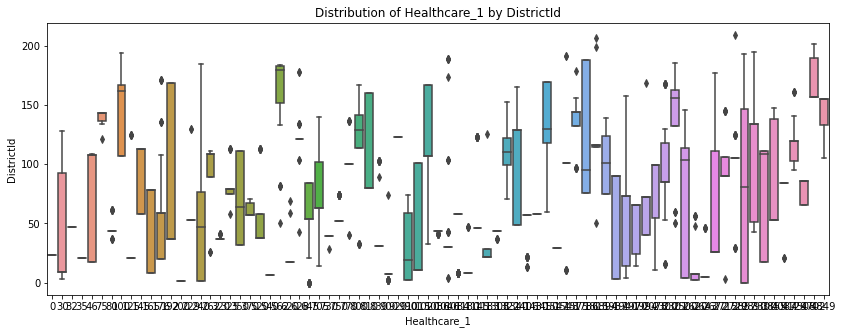

In [14]:
my_boxplot(df.Price,df.Healthcare_1[df.Healthcare_1.isna()==False],ampX=50000,ampY=1, f_e=(14, 5))
my_boxplot(df.Healthcare_1[df.Healthcare_1.isna()==False],df.DistrictId,ampX=1,ampY=1, f_e=(14, 5))

Этажи

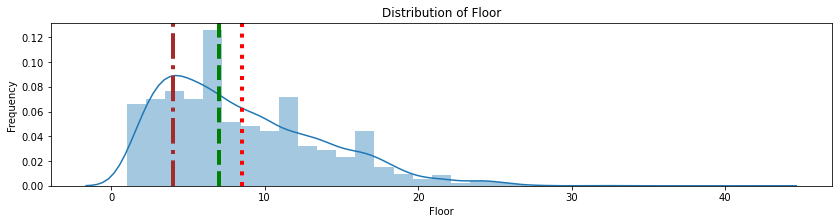

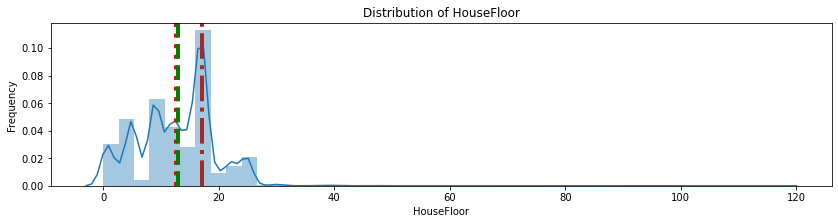

In [15]:
my_hist(df.Floor)
my_hist(df.HouseFloor)

В Московской области достаточно много высотных домов, и сложно сказать что есть выброс а что нет по верхней границе. Буду консервативен - все что выше 40 этажей - выброс

Проверяем корреляцию

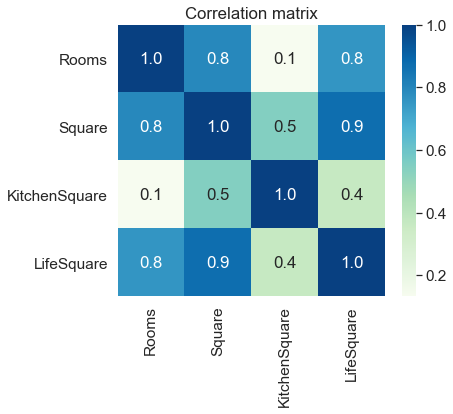

In [16]:
condition1 = ((df.Rooms > 0) & (df.Rooms<6))
condition2 = ((df.Square > 15) & (df.Square<280))
condition3 = ((df.KitchenSquare > 2) & (df.KitchenSquare<32))
condition4 = ((df.LifeSquare > 10) & (df.LifeSquare<240))

suspected_corr = df[['Rooms','Square','KitchenSquare','LifeSquare']][condition1&condition2&condition3&condition4]

corr = suspected_corr.corr()
plt.figure(figsize = (6, 5))
sns.set(font_scale=1.4)
sns.heatmap(suspected_corr.corr(), annot=True, fmt='.1f', cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

Корреляция отражает "шумность" и направление линейной зависимости - между этими признаками, как видно из матрицы корреляции ниже зависимость есть - буду ее использовать :)

2. Очистка данных

In [17]:
class F_Imputer:
    
    """Gap filling and emission handling"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'LifeSquare'] - X.loc[condition, 'KitchenSquare']
        
        # Square
        X.loc[X['Square'] > 400, 'Square'] = X.loc[X['Square'] > 400, 'Square'] / 10
        
        # HouseYear
        
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
        
        return X


3. Feature engineering

In [18]:
imputer = F_Imputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [19]:
class F_Genetator():
    """Generate New Features"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X) 
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            

In [20]:
features = F_Genetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

очищаем количественные данные для упрощения работы

In [21]:
r_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                    
                   'HouseFloor', 'HouseYear',
                   
                  'DistrictId_count',   'Ecology_3', 'Shops_2',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear','Ecology_2','Rooms_outlier', 'LifeSquare_nan', 'new_district','HouseYear_outlier']

X = X[r_features]
X_final = X_final[r_features]

Рассчет модели

In [22]:
model = LGBMRegressor(max_depth=33,
                             min_samples_leaf=10,
                             n_estimators=300,
                             random_state=41)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=41))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
R2: 0.736 +- 0.012


In [23]:
model.fit(X, y)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


LGBMRegressor(max_depth=33, min_samples_leaf=10, n_estimators=300,
              random_state=41)

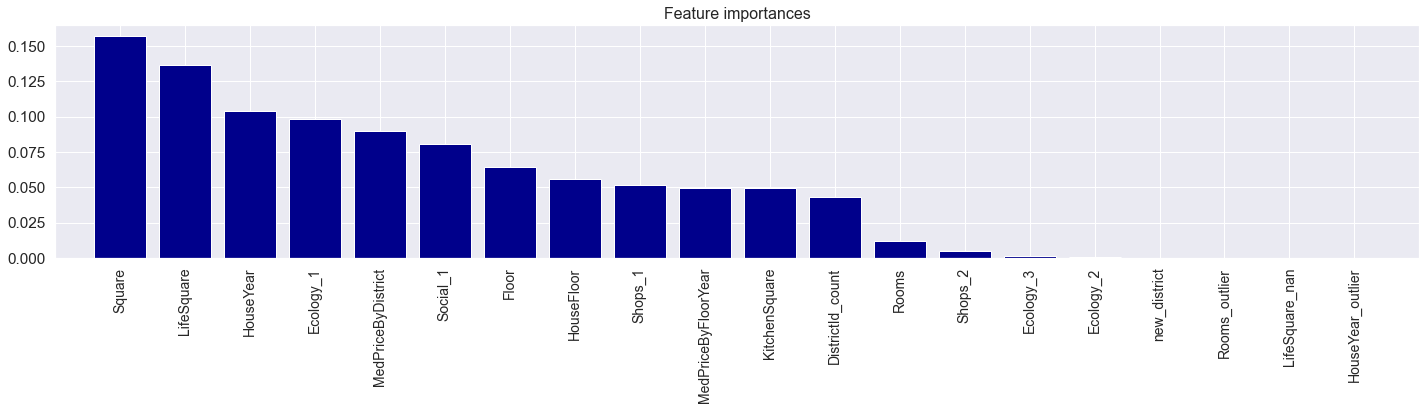

In [24]:
def plot_f_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_f_importances(importances = model.feature_importances_, X=X)

Tunning LGBMRegressor

In [25]:
model.get_params

<bound method LGBMModel.get_params of LGBMRegressor(max_depth=33, min_samples_leaf=10, n_estimators=300,
              random_state=41)>

In [26]:
np.arange(0.01, 0.05, 0.01)

array([0.01, 0.02, 0.03, 0.04])

In [27]:
parameters = [{
    'max_bin': np.arange(90, 120, 10),
    'n_estimators': np.arange(4000, 7000, 1000),
    'learning_rate': np.arange(0.01, 0.05, 0.01)
}]

In [28]:
clf = GridSearchCV(
    estimator=LGBMRegressor(random_state=41),
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=4,
    n_jobs=-1,
)

In [29]:
clf.fit(X, y)

GridSearchCV(cv=4, estimator=LGBMRegressor(random_state=41), n_jobs=-1,
             param_grid=[{'learning_rate': array([0.01, 0.02, 0.03, 0.04]),
                          'max_bin': array([ 90, 100, 110]),
                          'n_estimators': array([4000, 5000, 6000])}],
             scoring='neg_mean_squared_error')

Тестируем LGBMRegressor c наилучшими параметрами

In [33]:
model = LGBMRegressor(max_bin=110,
    n_estimators=4000,
    learning_rate=0.01)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=41))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.738 +- 0.009


In [31]:
model.fit(X, y)

LGBMRegressor(learning_rate=0.01, max_bin=110, n_estimators=4000)

In [32]:
y_pred_final = model.predict(X_final)
# test DATA Learn


preds_final['Price'] = y_pred_final
preds_final.to_csv('my_predictions_new.csv', index=False)

preds_final.head(10)

,Id,Price
0,725,156673.499129
1,15856,246045.989355
2,5480,121207.941330
3,15664,305149.735647
4,14275,153213.070154
5,7633,223439.108077
6,13329,164559.081005
7,5502,216778.642552
8,4220,276887.137936
9,11538,198038.992571
